In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
seed = 12
tf.random.set_seed(seed)

# Load Reuters Dataset

In [3]:
keras = tf.keras
reuters = keras.datasets.reuters
(x_train,y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

In [4]:
x_test.shape

(10000, 32, 32, 3)

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
def confusion_matrix_generate(real_y,x,model):
    pred = np.argmax(model.predict(x),1)
    c_matrix = confusion_matrix(y_test, pred)
    labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    display = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    display.plot(ax=ax)
    print(classification_report(real_y, pred))

# Normalise Dataset

In [7]:
x_train_norm,x_test_norm = x_train / 255.0, x_test / 255.0
x_train_norm_flat, x_test_norm_flat = x_train_norm.flatten().reshape(50000, 32*32*3), x_test_norm.flatten().reshape(10000, 32*32*3)

In [8]:
x_train_norm_flat[1:100].shape

(99, 3072)

In [9]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

# Logistic Regression

In [283]:
clf = LogisticRegression(random_state=0).fit(x_train_norm_flat[1:50000], y_train[1:50000].ravel())

C:\Users\Winothy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clf.score(x_test_norm_flat, y_test.ravel())
pred = clf.predict(x_test_norm_flat)

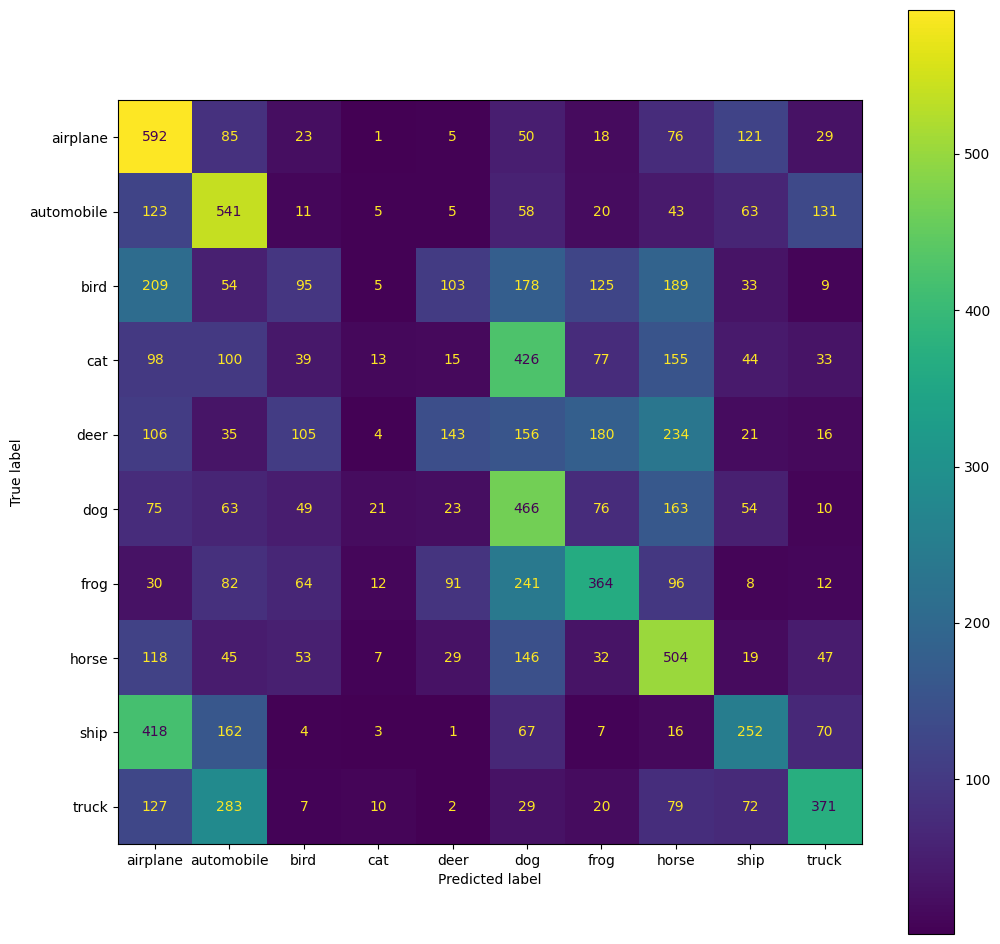

In [291]:
c_matrix = confusion_matrix(y_test, pred)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
display = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
display.plot(ax=ax)

Does worse than random chance, so not particularly useful, and was not able to converge.

# SVM Models

## Linear SVM

In [17]:
svm_linear = svm.SVC(kernel='linear',max_iter=1000)
svm_linear.fit(x_train_norm_flat[1:20000], y_train[1:20000].ravel())

C:\Users\Winothy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000)

In [19]:
svm_linear.score(x_test_norm_flat, y_test.ravel())

0.2724

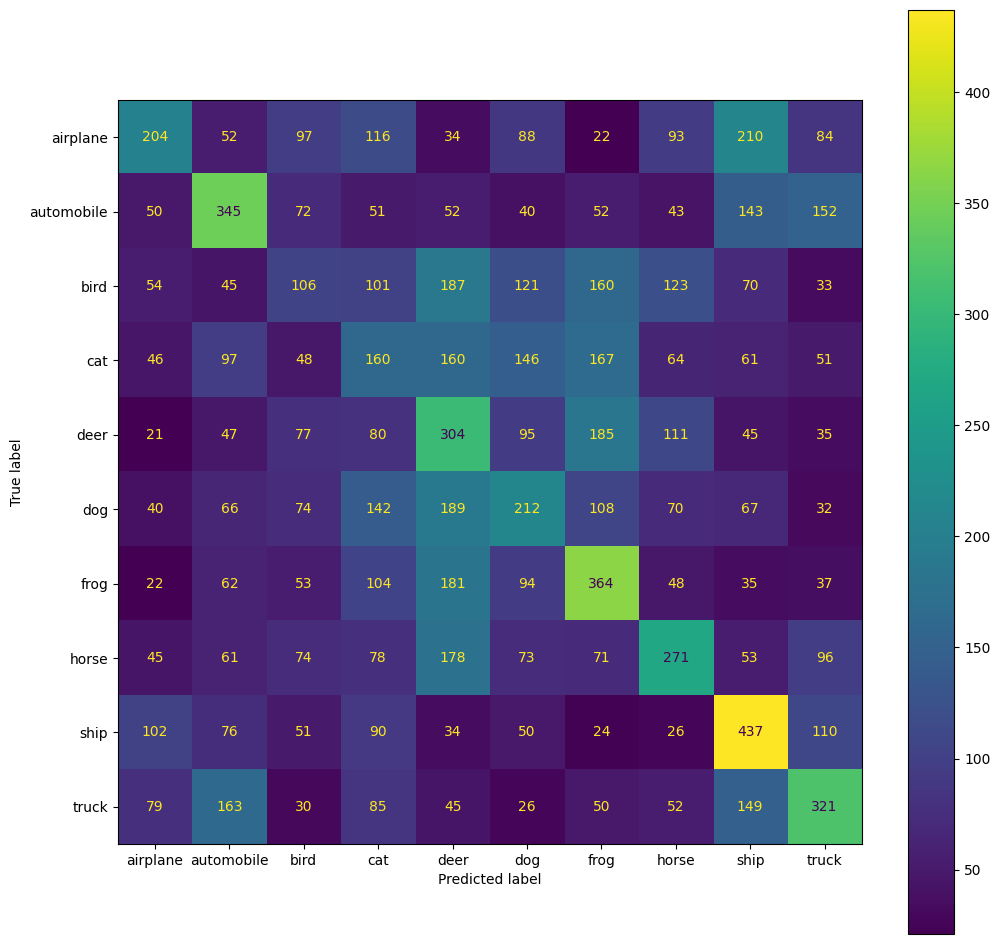

In [18]:
pred = svm_linear.predict(x_test_norm_flat)
c_matrix = confusion_matrix(y_test, pred)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
display = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
display.plot(ax=ax)

The Linear SVM model is also terrible, and is a lot more computationally expensive compared to logistic regression. It doesn't have as many hotspots in where its completely wrong, it's mostly spread out.

## Kernel Poly SVM

In [11]:
svm_poly = svm.SVC(kernel='poly',max_iter=1000)
svm_poly.fit(x_train_norm_flat[1:20000], y_train[1:20000].ravel())

C:\Users\Winothy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='poly', max_iter=1000)

In [12]:
svm_poly.score(x_test_norm_flat, y_test.ravel())

0.3377

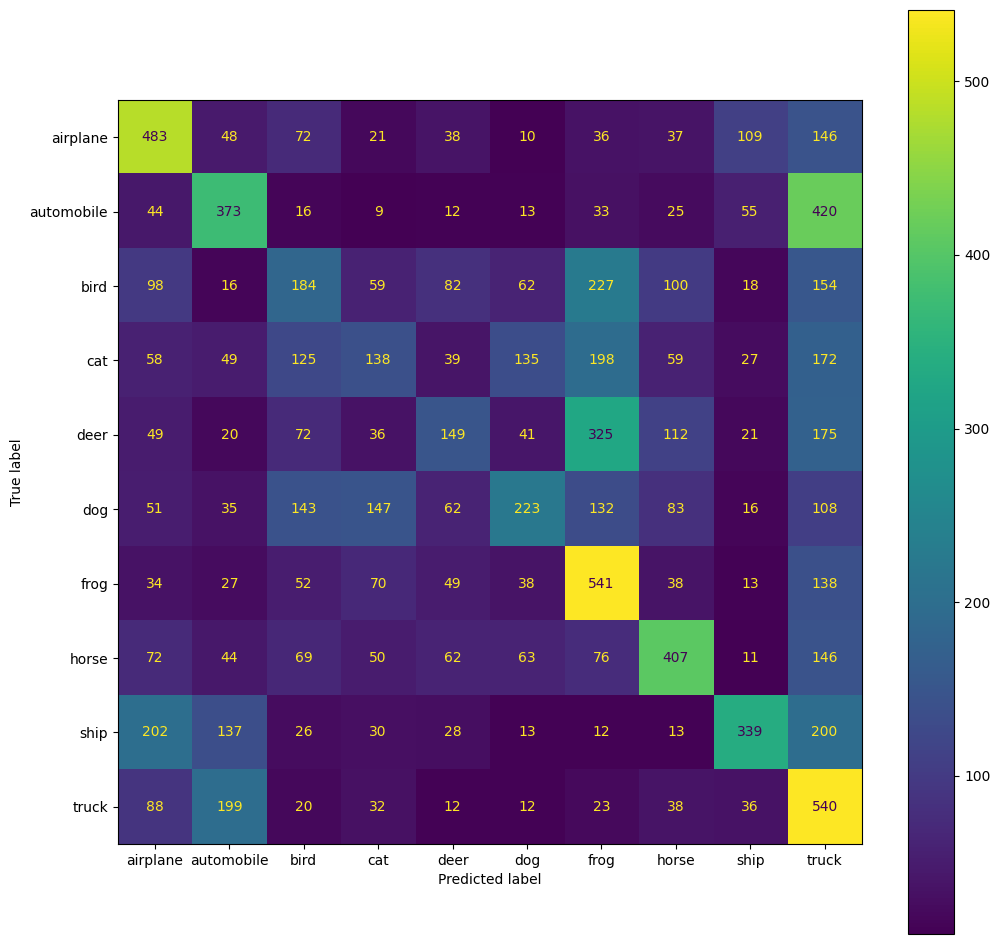

In [15]:
svm_poly = svm_linear
pred = svm_poly.predict(x_test_norm_flat)
c_matrix = confusion_matrix(y_test, pred)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
display = ConfusionMatrixDisplay(confusion_matrix=c_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
display.plot(ax=ax)

It's a bit better, but is still worse than random chance. The truck classifier is biased, however.

# Build Basic Neural Network

In [140]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,32,3)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

C:\Users\Winothy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [194]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [195]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

model.fit(x_train_norm,y_train,epochs=25,validation_data=(x_test_norm, y_test),callbacks=[callback])

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3050 - loss: 1.8817 - val_accuracy: 0.3569 - val_loss: 1.7745
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3130 - loss: 1.8673 - val_accuracy: 0.3635 - val_loss: 1.7654
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3130 - loss: 1.8648 - val_accuracy: 0.3585 - val_loss: 1.7699
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3101 - loss: 1.8661 - val_accuracy: 0.3660 - val_loss: 1.7544
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3182 - loss: 1.8577 - val_accuracy: 0.3689 - val_loss: 1.7482
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3190 - loss: 1.8498 - val_accuracy: 0.3746 - val_loss: 1.7408
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3205 - loss: 1.8471 - val_accuracy: 0.3702 - val_loss: 1.7368
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3213 - loss: 1.8487 - 

# Evaluate Model

In [204]:
model.evaluate(x_test_norm,y_test,verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.3869 - loss: 1.7195


[1.7195093631744385, 0.38690000772476196]

In [164]:
pred = np.argmax(model.predict(x_test),1)
pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


array([8, 1, 8, ..., 5, 5, 7], dtype=int64)

In [145]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
              precision    recall  f1-score   support

           0       0.44      0.44      0.44      1000
           1       0.49      0.57      0.53      1000
           2       0.24      0.14      0.18      1000
           3       0.23      0.18      0.20      1000
           4       0.32      0.17      0.22      1000
           5       0.38      0.32      0.35      1000
           6       0.33      0.67      0.44      1000
           7       0.42      0.52      0.47      1000
           8       0.48      0.41      0.44      1000
           9       0.47      0.45      0.46      1000

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.37     10000
weighted avg       0.38      0.39      0.37     10000



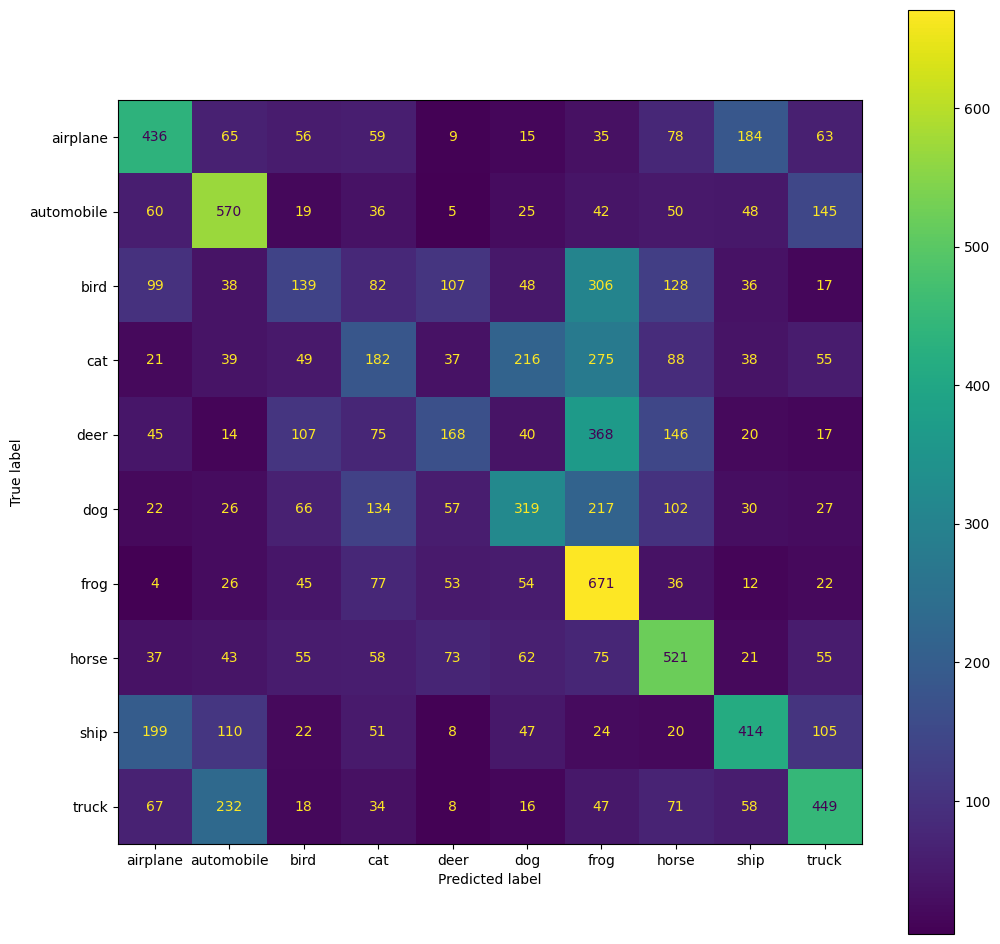

In [206]:
confusion_matrix_generate(y_test,x_test_norm,model)

The model doesn't perform well either. Though it seems to differentiate between animals and vehicles quite well. It is also obvious that it doesnt do well between these vehicles, as airplane and automobile are mixed up in the matrix, through a truck and airplane are quite separated in the model

# Building a Sobel shallow model

Let's try to use edge detection to improve the performance of the model. HOG won't work on such a small image so the sobel filter is instead applied. It can be seen as a minor convulution using the sobel 3x3 filter.

In [171]:
from skimage.feature import hog
from skimage import data, exposure
from skimage import data

from skimage import filters
from skimage.color import rgb2gray

In [172]:
grayscale = rgb2gray(x_train[1])
edges = filters.sobel(grayscale)

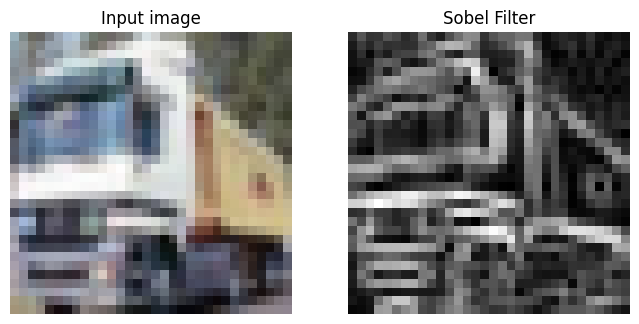

In [173]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(x_train[1], cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Sobel Filter')
plt.show()

## Apply filter to entire dataset

In [198]:
def dataset_to_edges(data):
    new_data = []
    for img in data:
        grayscale = rgb2gray(img)
        edges = filters.sobel(grayscale)
        new_data.append(edges)
    return np.asarray(new_data)

x_train_edges, x_test_edges = dataset_to_edges(x_train), dataset_to_edges(x_test)

In [175]:
x_train_edges.shape

(50000, 32, 32)

## Build and train basic model

In [191]:
model_sobal = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32,32,1)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_sobal.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [192]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

model_sobal.fit(x_train_edges,y_train,epochs=25,validation_data=(x_test_edges, y_test),callbacks=[callback])

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2408 - loss: 2.0878 - val_accuracy: 0.3244 - val_loss: 1.9011
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3226 - loss: 1.8898 - val_accuracy: 0.3488 - val_loss: 1.8324
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3539 - loss: 1.8193 - val_accuracy: 0.3578 - val_loss: 1.8039
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3735 - loss: 1.7706 - val_accuracy: 0.3707 - val_loss: 1.7779
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3844 - loss: 1.7372 - val_accuracy: 0.3748 - val_loss: 1.7639
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3957 - loss: 1.7073 - val_accuracy: 0.3754 - val_loss: 1.7619
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4032 - loss: 1.6830 - val_accuracy: 0.3887 - val_loss: 1.7427
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4122 - loss: 1.6571 - 

In [200]:
model_sobal.evaluate(x_test_edges,y_test,verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.3869 - loss: 1.7460


ValueError: not enough values to unpack (expected 5, got 2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
              precision    recall  f1-score   support

           0       0.54      0.44      0.48      1000
           1       0.38      0.52      0.44      1000
           2       0.36      0.34      0.35      1000
           3       0.26      0.15      0.19      1000
           4       0.35      0.32      0.34      1000
           5       0.35      0.28      0.31      1000
           6       0.38      0.54      0.44      1000
           7       0.40      0.42      0.41      1000
           8       0.46      0.43      0.45      1000
           9       0.37      0.42      0.40      1000

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.38     10000
weighted avg       0.38      0.39      0.38     10000



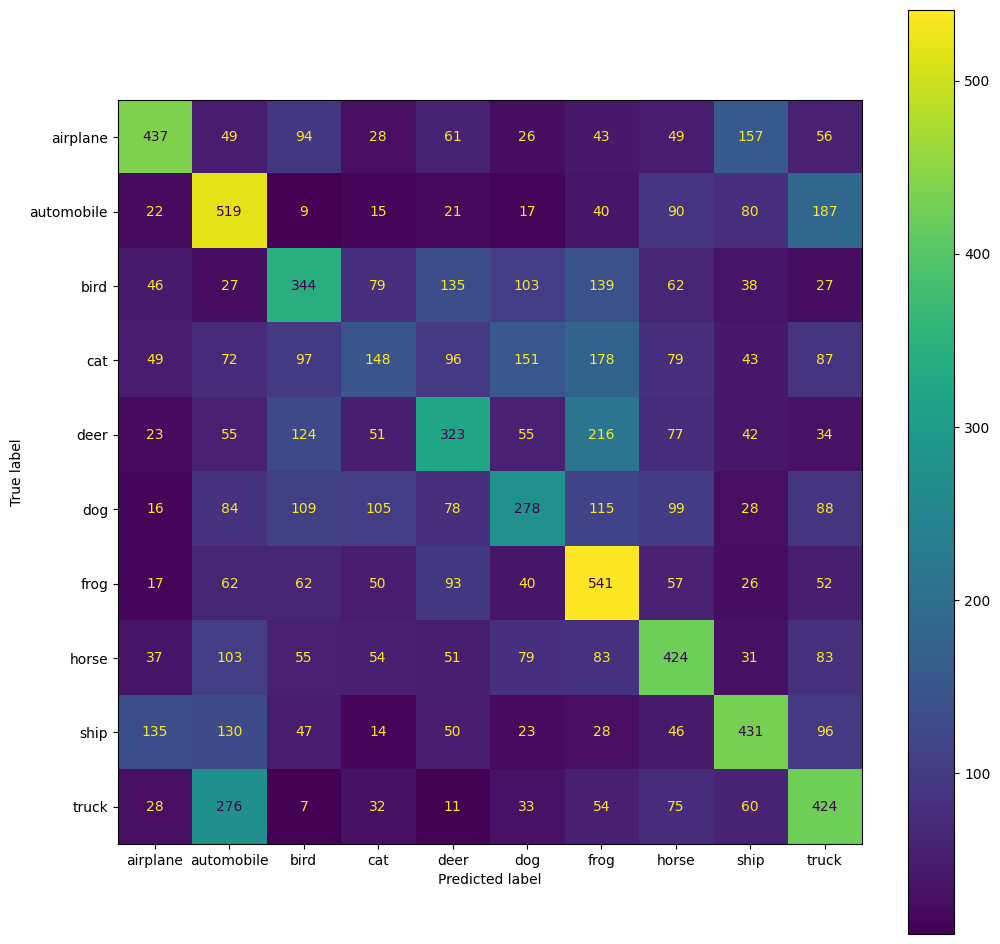

In [205]:
confusion_matrix_generate(y_test,x_test_edges,model_sobal)

Although the accuracy is about identical, the confusion matrix shows that there seems to be less ambiguity in the decision, as the diagonal is less chaotic. The only other thing to note is that the edge input helped the training speed, as it only took 3 epochs to reach its max validation potential, versus the other models 17 epochs.


# Building a Deep Learning CNN

In [243]:
layers = tf.keras.layers
num_filters = 32

model_cnn = tf.keras.models.Sequential([
    layers.Input((32, 32, 3)),
    layers.Conv2D(num_filters, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters*2, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters*2, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

model_cnn.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,954 (480.29 KB)

 Trainable params: 122,762 (479.54 KB)

 Non-trainable params: 192 (768.00 B)

In [245]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_cnn.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

model_cnn.fit(x_train,y_train,epochs=25,validation_data=(x_test, y_test),callbacks=[callback])

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7355 - loss: 0.7577 - val_accuracy: 0.6788 - val_loss: 0.9383
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7657 - loss: 0.6702 - val_accuracy: 0.6911 - val_loss: 0.9403
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7935 - loss: 0.5863 - val_accuracy: 0.6815 - val_loss: 1.0131
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8150 - loss: 0.5219 - val_accuracy: 0.6579 - val_loss: 1.1139
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8388 - loss: 0.4602 - val_accuracy: 0.6714 - val_loss: 1.1347
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8547 - loss: 0.4094 - val_accuracy: 0.6433 - val_loss: 1.3422


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      1000
           1       0.84      0.74      0.78      1000
           2       0.50      0.64      0.56      1000
           3       0.40      0.53      0.46      1000
           4       0.55      0.60      0.58      1000
           5       0.69      0.42      0.52      1000
           6       0.60      0.88      0.71      1000
           7       0.86      0.56      0.68      1000
           8       0.78      0.76      0.77      1000
           9       0.78      0.72      0.75      1000

    accuracy                           0.64     10000
   macro avg       0.67      0.64      0.65     10000
weighted avg       0.67      0.64      0.65     10000



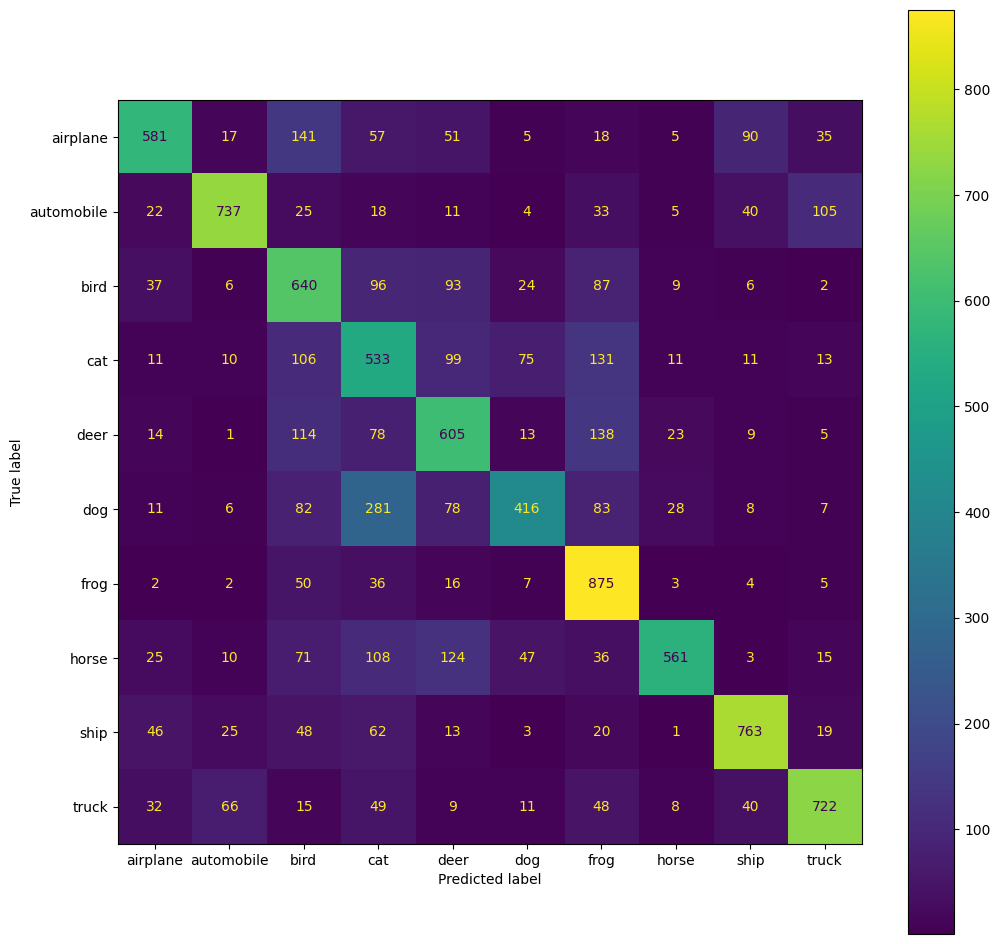

In [246]:
confusion_matrix_generate(y_test,x_test,model_cnn)

This shows a much better consistency, and you can see the main conufusion is around the centre of the graph. Also funnily it is confusing planes with birds, and trucks with automobiles. Essentially it has got down the easy stuff, and the harder stuff of similar features it sitll struggles with.